<a href="https://colab.research.google.com/github/sdeshmukh99/Generative-AI-Showcase/blob/main/Showcase_06/Spam_Classification_Pipeline_with_Vectorization_and_Embedding_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1: Get the Dataset and Import Necessary Packages

In [1]:
#Download the Dataset
!wget https://cdn.exec.talentsprint.com/static/aimlops/c3/spam.csv

# Import necessary packages for data manipulation, plotting, and machine learning

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# TensorFlow for building and training the model
import tensorflow as tf

# Scikit-learn for model selection and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


--2024-10-09 06:52:47--  https://cdn.exec.talentsprint.com/static/aimlops/c3/spam.csv
Resolving cdn.exec.talentsprint.com (cdn.exec.talentsprint.com)... 172.105.52.210
Connecting to cdn.exec.talentsprint.com (cdn.exec.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [application/octet-stream]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   554KB/s    in 0.9s    

2024-10-09 06:52:51 (554 KB/s) - ‘spam.csv’ saved [503663/503663]



# 2: Read the Data

In [2]:
# Read the CSV file
df = pd.read_csv('spam.csv', encoding='latin-1')

# Drop unnamed columns and rename the remaining ones
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})

# Display the first few rows and basic information about the dataset
print(df.head())
print(df.info())

# Check class distribution
print(df['label'].value_counts())

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

#print dataset summary
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64
Training set size: 4457
Testing set size: 1115


# 3: Apply the Vectorization

## 3.1: Define and Compile the Model

In [13]:
# Define model parameters
embedding_dim = 256
max_vocab_size = 10000  # Assuming this was defined earlier
max_sequence_length = 100  # Assuming this was defined earlier

# Define the model architecture with named layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_sequence_length,), name='input_layer'),
    tf.keras.layers.Embedding(max_vocab_size, embedding_dim, name='embedding_layer'),
    tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_relu'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print model summary
print(model.summary())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ (None, 100, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool                      │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_relu (Dense)                   │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,576,513 (9.83 MB)

 Trainable params: 2,576,513 (9.83 MB)

 Non-trainable params: 0 (0.00 B)

None


## 3.2 Create Text Vectorization Layer and Prepare Dataset

In [14]:
# Create a TextVectorization layer
max_vocab_size = 10000
max_sequence_length = 100

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length
)

# Adapt the vectorizer to the training text data
vectorizer.adapt(X_train.values)

# Create vectorized datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Function to vectorize and format the dataset
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorizer(text), label

# Apply vectorization to the datasets
train_ds = train_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

# Cache and prefetch the datasets for better performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# 4: Extract the Embeddings before Training


In [15]:
# 4: Extract the Initial Embeddings

# Build the model by passing a dummy input to initialize the weights
model(tf.zeros((1, max_sequence_length)))

# Optional: Print model layers for verification
print("Number of layers in the model:", len(model.layers))
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}: {layer.name} ({layer.__class__.__name__})")

# Access the Embedding layer by name
embedding_layer = model.get_layer('embedding_layer')

# Get the initial embeddings
initial_embeddings = embedding_layer.get_weights()[0]

# Print the shape of the initial embeddings
print("Shape of initial embeddings:", initial_embeddings.shape)




Number of layers in the model: 4
Layer 0: embedding_layer (Embedding)
Layer 1: global_avg_pool (GlobalAveragePooling1D)
Layer 2: dense_relu (Dense)
Layer 3: output_layer (Dense)
Shape of initial embeddings: (10000, 256)


# 5: Train the Model

In [16]:
# Train the model and store the training history
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8389 - loss: 0.4034 - val_accuracy: 0.8655 - val_loss: 0.3577
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.3444 - val_accuracy: 0.8655 - val_loss: 0.2625
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9032 - loss: 0.2279 - val_accuracy: 0.9614 - val_loss: 0.1257
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0919 - val_accuracy: 0.9605 - val_loss: 0.1503
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9798 - loss: 0.0767 - val_accuracy: 0.9650 - val_loss: 0.1348
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9847 - loss: 0.0635 - val_accuracy: 0.9731 - val_loss: 0.1075
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9870 - loss: 0.0495 - val_accuracy: 0.9749 - val_loss: 0.1046
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9906 - loss: 0.0435 - val_accuracy: 0

In [17]:
# Verifying if the keys you are trying to plot exist in the history object.
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


# 6: During Training Collect and Plot Metrics

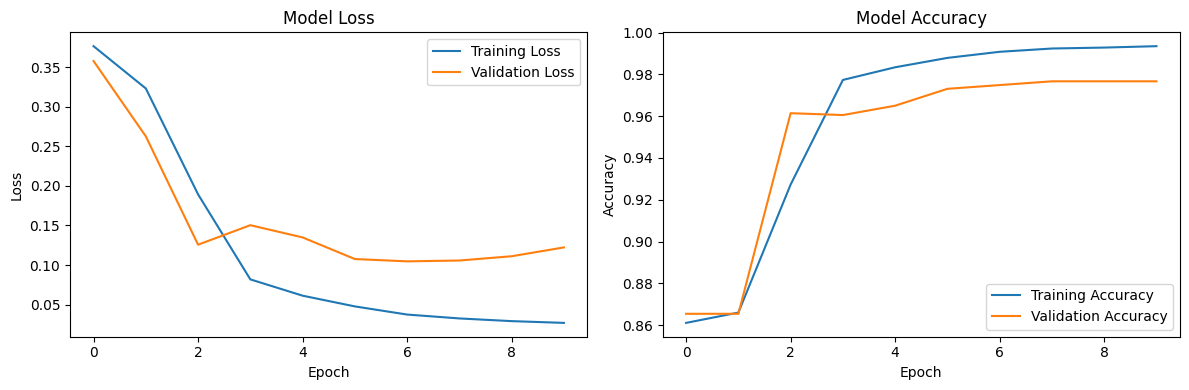

In [18]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 4))

# Subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust subplot parameters to give specified padding and prevent overlap
plt.tight_layout()

# Display the final figure
plt.show()

# 7: Calculate and Display the Test Performance

In [19]:
# Evaluate the model on the test dataset and return the loss and accuracy
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test accuracy with 4 decimal places
print(f"Test accuracy: {test_accuracy:.4f}")

# Print the test loss with 4 decimal places
print(f"Test loss: {test_loss:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9842 - loss: 0.0844
Test accuracy: 0.9767
Test loss: 0.1222


# 8: Extract the Embeddings after Training

In [20]:
# 8: Extract the Embeddings after Training

# Get the embedding layer from the model by name
embedding_layer = model.get_layer('embedding_layer')

# Retrieve the learned embeddings (weights) from the embedding layer
learned_embeddings = embedding_layer.get_weights()[0]

# Print the shape of the learned embeddings (number of tokens, embedding dimensions)
print("Shape of learned embeddings:", learned_embeddings.shape)


Shape of learned embeddings: (10000, 256)


# 9: Reduce the Embeddings using PCA

In [21]:
# Import the PCA class for dimensionality reduction from the scikit-learn library
from sklearn.decomposition import PCA

# Perform Principal Component Analysis (PCA) to reduce the dimensionality of embeddings to 2 components
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(learned_embeddings)

# Print the shape of the reduced embeddings (number of tokens, reduced dimensions)
print("Shape of reduced embeddings:", reduced_embeddings.shape)


Shape of reduced embeddings: (10000, 2)


# 10: Plot the Embeddings in 2D

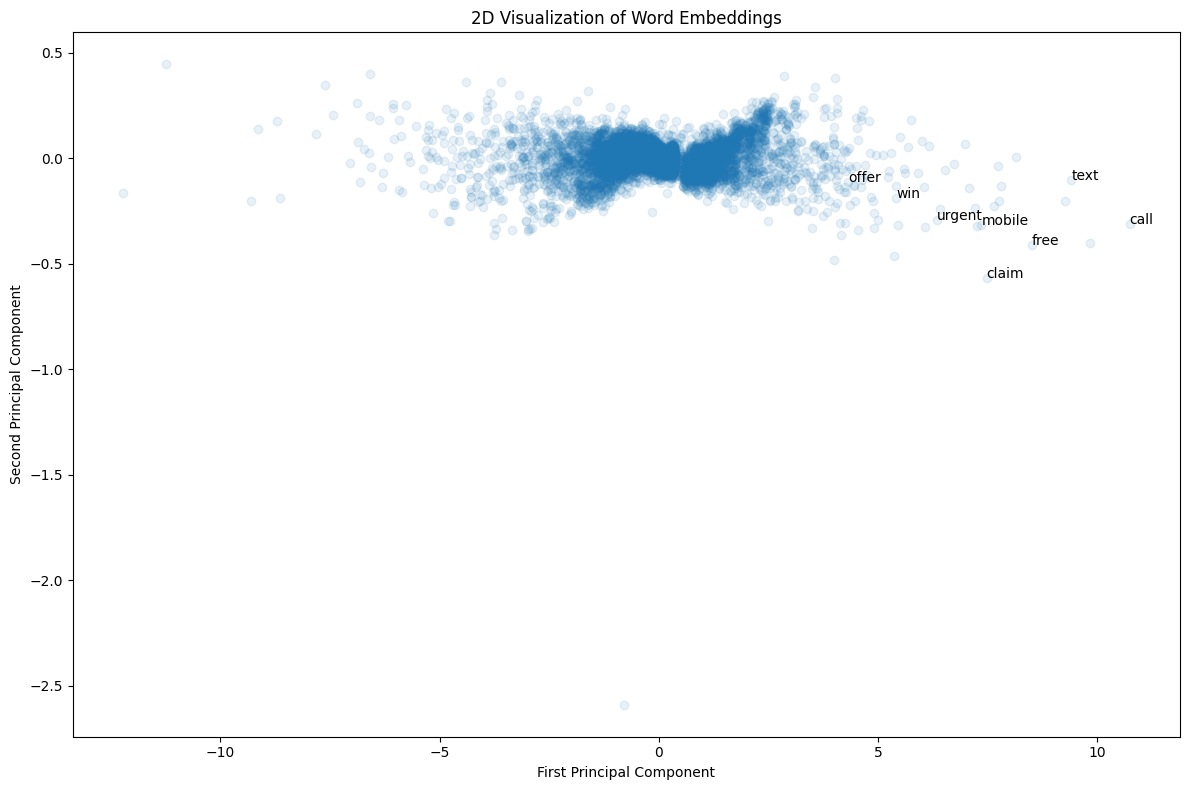

In [22]:
# Create a figure with a specified size for the plot
plt.figure(figsize=(12, 8))

# Create a scatter plot of the reduced embeddings on the first and second principal components
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.1)
plt.title('2D Visualization of Word Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot specific words on the 2D embedding space
words_to_plot = ['free', 'win', 'call', 'text', 'mobile', 'claim', 'urgent', 'offer']
vocabulary = vectorizer.get_vocabulary()
for word in words_to_plot:
    try:
        # Find the index of the word in the vocabulary and annotate it on the plot
        idx = vocabulary.index(word)
        plt.annotate(word, (reduced_embeddings[idx, 0], reduced_embeddings[idx, 1]))
    except ValueError:
        # Handle the case where the word is not found in the vocabulary
        print(f"Word '{word}' not found in vocabulary")

# Adjust the layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()
